## Final Model 


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
# recommended models
from keras.applications import vgg16
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import keras

#CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import datetime
# from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
#import resnet50
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
# get the array with the class names from the folder 
# read foldernames
import os
import glob
import cv2



In [2]:
# import tf.keras.callbacks.ModelCheckpoint


In [3]:
# find how many tunic we have 
# more = ['Swimwear', 'Shoe Laces', 'Tunics', 'Messenger Bag', 'Sweatshirts',
#         'Water Bottle', 'Footballs', 'Wallets', 'Laptop Bag', 'Rucksacks',
#         'Waist Pouch', 'Leggings', 'Bra', 'Trousers', 'Headband', 'Belts',
#         'Travel Accessory']
# names = []
# for i in more:
#     names.append(styles.loc[styles['articleType'] ==i]["id"])
# styles.loc[styles['articleType'] == "Shoe Laces"]

In [4]:
# keep only the rows with image names that exists in any of the existing folders of the Imagesfromfashiondataset

# styles["image_name"]= styles["id"].astype(str) + ".jpg"

# # new_style = styles[styles['image_name'].isin(os.listdir('Imagesfromfashiondataset/'))]

# # selected_styles = styles[styles['image_name'].isin(os.listdir(
# #     'Imagesfromfashiondataset/'))]
# selected_styles = styles[styles['image_name'].isin(
#     [filename for folder in os.listdir('Imagesfromfashiondataset/')
#      for filename in os.listdir(os.path.join('Imagesfromfashiondataset/', folder))]
# )]


In [5]:
# read all the paths from the folder
def get_paths(folder):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            # if file.endswith(".jpg"):
            paths.append(os.path.join(root, file))
    return paths

In [6]:
shop_images = get_paths(
    r'C:\Users\mrpal\OneDrive\Desktop\WBS\fashcam\asos')


In [7]:
shop_images


['C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image0.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image1.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image100.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image1000.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10000.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10001.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10002.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10003.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10004.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10005.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10006.jpg',
 'C:\\Users\\mrpal\\OneDrive\\Desktop\\WBS\\fashcam\\asos\\image10007.jpg',
 'C:\\Users\\mrpal\\OneDri

## function that loads all models

In [8]:
from keras.applications.vgg19 import VGG19

def get_models():
  # load the vgg models
  vgg16_model = vgg16.VGG16(weights='imagenet')
  vgg19_model = VGG19(weights='imagenet', include_top=False)
  # remove the last layers in order to get features instead of predictions
  feat_extractor_vgg19 = Model(inputs=vgg19_model.input,
                               outputs=vgg19_model.get_layer("block5_pool").output)
  feat_extractor = Model(inputs=vgg16_model.input,
                         outputs=vgg16_model.get_layer("fc2").output)
  # get the model with the last layer in order to get predictions
  classifier = Model(inputs=vgg16_model.input,
                     outputs=vgg16_model.get_layer("predictions").output)
  # print the layers of the CNN
  feat_extractor.summary()
  # feat_extractor_vgg19.summary()
  classifier.summary()
  return feat_extractor, classifier, feat_extractor_vgg19
    

In [9]:
feat_extractor = get_models()[0]
classifier = get_models()[1]
feat_extractor_vgg19 = get_models()[2]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### function that uses resnet to predict the class and the sparse matrix of image given

 ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database.
 the model has over 23 million trainable parameters

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def get_prediction_resnet(img_path):

    # Load the pre-trained ResNet50 model, with the top layer removed
    model = ResNet50(weights='imagenet', include_top=True)

    # Load an image to use for prediction
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get the predictions from the model
    features = model.predict(x)

    # Print the top 5 predictions
    predictions = decode_predictions(features, top=2)
    # for p in predictions[0]:
    #     print(f"Class: {p[1]}, Probability: {p[2]:.2f}")
    return predictions[0][0]
    
    

## here we drop outliers or misclasifications and define our unique types

In [11]:
# read the folder names from the C:\Users\mrpal\OneDrive\Desktop\WBS\fascam\clothing-dataset-small\train save them to a list
unique_types = [
    folder for folder in os.listdir(r'C:\Users\mrpal\OneDrive\Desktop\WBS\fashcam\finalDataset')]


unique_types


['Backpacks',
 'Belts',
 'Bra',
 'Capris',
 'Caps-hats',
 'Casual Shoes',
 'Clutches',
 'Dresses',
 'Earrings',
 'Flip Flops',
 'Handbags',
 'Heels',
 'Jeans',
 'Jewellery_Set',
 'Kurtas',
 'Leggings',
 'Outwear',
 'pijamas',
 'Ring',
 'Salwar',
 'Sandals',
 'Scarves',
 'Shirts',
 'Shorts',
 'Skirts',
 'Socks',
 'Sports Shoes',
 'Sunglasses',
 'Sweatshirts',
 'Swimwear',
 'Tops',
 'Track Pants',
 'Tracksuits',
 'Trousers',
 'Tshirts',
 'Tunics',
 'Wallets',
 'Watches']

SNIPPET TO REMOVE EVERY PHOTO FROM THE FOLDERPATH TO THE OTHER FOLDERS THAT BELONG

In [12]:

#import shutil
#folderpath= r'C:\Users\mrpal\OneDrive\Desktop\WBS\machineLearning\supervised\deeplearning\Imagesfromfashiondataset\only' 
# # for each row in the dataframe
# for index, row in selected_styles.iterrows():
#     # get the image name
#     image_name = row['image_name']
#     # get the type of clothing
#     type = row['articleType']
#     # get the source path to the image
#     src = os.path.join(r"folderpath", image_name).replace("\\", "/")
  
#     # get the destination path to the image
#     dst = r'Imagesfromfashiondataset/'+os.path.join(type, image_name).replace("\\", "/")
#     # move the image from the source to the destination
#     # print(src, dst)
#     shutil.move(src, dst)


In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\mrpal\OneDrive\Desktop\WBS\fashcam\finalDataset",
    labels="inferred",
    label_mode='categorical',
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)
# split the data into train and test



Found 14223 files belonging to 38 classes.


In [14]:
# import output 
def train_model_tuning():
    # Load the pre-trained ResNet50 model, with the top layer removed
    resnet50_model = ResNet50(
        weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    #model with 1 layer
    cnn_model = resnet50_model.output
    cnn_model = Flatten()(cnn_model)
    cnn_model = Dense(len(unique_types), activation='softmax')(cnn_model)
    # for the 1117 classes
    # cnn_model = Dense(len(unique_types), activation='softmax')(cnn_model)
    final_model = Model(inputs=resnet50_model.input, outputs=cnn_model)

    # Freeze all layers in the base model (except for the top layer)
    for layer in resnet50_model.layers:
        layer.trainable = False
    # Compile the model
    final_model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Convert the target labels into one-hot encoded format
    checkpoint_filepath = r'C:\Users\mrpal\OneDrive\Desktop\WBS\fashcam'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    
    # Train the model
    
    history = final_model.fit(
        train_data, 
        batch_size=130, 
        epochs=40, 
        verbose=1,
        callbacks=[model_checkpoint_callback],
        )
  
    # save the model
    # serialize model to JSON
    model_json = final_model.to_json()
    with open("final_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    final_model.save_weights("final_model.h5")
    print("Saved model to disk")
    
    return 0


# train_model_tuning()


### function that uses fine tunin with resnet50 to predict the class and the sparse matrix of image given

In [15]:
def get_prediction_tuning(img_path):
    # load json and create model
    json_file = open('final_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("final_model.h5")
    # Load an image to use for prediction
    img = load_img(img_path, target_size=(224, 224,3))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # result = loaded_model.predict(x)
    # evaluate loaded model on test data
    loaded_model.compile(optimizer='adam', loss='categorical_crossentropy',
                         metrics=['accuracy'])
    result = loaded_model.predict(x)
    return (result,unique_types[np.argmax(result)])
    
    
    
  


In [17]:
json_file = open('final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("final_model.h5")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])       
score = loaded_model.evaluate(train_data[:150], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)) 

TypeError: 'BatchDataset' object is not subscriptable

In [19]:
train_size = int(0.8 * len(train_data))
test_size = int(0.2 * len(train_data))

train_dataset = train_data.take(train_size)
test_dataset = train_data.skip(test_size)
test_x = test_dataset.take(1)
test_y = test_dataset.skip(1)

In [21]:
# # confusion matrix
#import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
Y_pred = loaded_model.predict(test_x[:50])
y_pred = np.argmax(test_y, axis=1)
y_true = np.argmax(test_y[:50], axis=1)
confusion_matrix(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)   
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: name 'test_x' is not defined

### function that uses vgg16 model to predict the class and the sparse matrix of image given

VGG-19 is an improved version of vgg16 and it is 19 layers deep.  a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals

In [ ]:
def get_prediction_vgg16(img_path):
    # imgs_model_width, imgs_model_height = 224, 224
    # load the model
    vgg_model = vgg16.VGG16(weights='imagenet')

    original = load_img(img_path, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    images = np.vstack([image_batch])

    processed_img = preprocess_input(images.copy())
    prediction = classifier.predict(images)
    result = feat_extractor.predict(images)
    # help the model to predict the class
    return result, vgg16.decode_predictions(prediction, top=1)[0][0][1]


In [ ]:
# # load the model
# vgg_model = vgg16.VGG16(weights='imagenet')

# # remove the last layers in order to get features instead of predictions

# feat_extractor = Model(inputs=vgg_model.input,
#                        outputs=vgg_model.get_layer("fc2").output)
# # get the model with the last layer in order to get predictions
# classifier = Model(inputs=vgg_model.input,
#                      outputs=vgg_model.get_layer("predictions").output)

# # print the layers of the CNN
# feat_extractor.summary()
# classifier.summary()

### testing all models

In [ ]:
test_file = r"C:\Users\mrpal\OneDrive\Desktop\WBS\machineLearning\supervised\deeplearning\image3.jpg"

get_prediction_prachi((test_file))[1]
get_prediction_vgg16(test_file)[1]
get_prediction_resnet(test_file)[1]
get_prediction_tuning(test_file)[1]
# give a black frame to the picture through load image and then show it:
original = load_img(test_file)
plt.imshow(original)
print("prachi says " + get_prediction_prachi(test_file)[1])
print("vgg16 says " + get_prediction_vgg16(test_file)[1])
print("resnet says " + get_prediction_resnet(test_file)[1])
print ("tuned model says " + get_prediction_tuning(test_file)[1])


1/1 [==============================] - 0s 82ms/step


: 

In [ ]:
# feat_extractor.predict(preprocess_input(np.expand_dims(load_img(r'C:\Users\mrpal\OneDrive\Desktop\WBS\machineLearning\supervised\deeplearning\FasCam\clothing-dataset-small\dress\009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg', target_size=(imgs_model_width, imgs_model_height)), axis=0)))

### function that gets a list of images and returns the features of those images

In [ ]:
# function that gets a list of images and returns the features of those images
def get_features(img_paths, category_folder_name):
    imgs_model_width, imgs_model_height = 224, 224
    nb_closest_images = 5
    importedImages = []
    for f in img_paths:
        filename = f
        original = load_img(filename, target_size=(224, 224))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        importedImages.append(image_batch)
    images = np.vstack(importedImages)
    processed_imgs = preprocess_input(images.copy())
    # load the model
    vgg_model = vgg16.VGG16(weights='imagenet')
    # remove the last layers in order to get features instead of predictions
    feat_extractor = Model(inputs=vgg_model.input,
                           outputs=vgg_model.get_layer("fc2").output)
    # print the layers of the CNN
    feat_extractor.summary()
    imgs_features = feat_extractor.predict(processed_imgs)
    print("features successfully extracted!")
    # save it as csv file
    np.savetxt(f'{category_folder_name}.csv', imgs_features, delimiter=",")
    return imgs_features

In [ ]:
get_features(list_directory[:5000], 'imagesfromfashiondata')


### function that takes an image as input and applies the cosine similarity with the features from csv to get the closest images


In [ ]:
# function that takes an image as input and applies the cosine similarity with the features from csv to get the closest images
def get_closest_images(img_path, nb_closest_images=4):
    # prediction about the class of the image
    available_class = get_prediction_prachi(img_path)
    available_class = "outwear"
    # load the features from csv

    features = np.genfromtxt(f'{available_class}.csv', delimiter=',')
    # get the features of the image
    img_features = feat_extractor.predict( preprocess_input(np.expand_dims(load_img(img_path, target_size=(224, 224)), axis=0)))
    # get the cosine similarity
    cosSimilarities = cosine_similarity(img_features, features)

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(img_path, target_size=(
        224, 224))
    plt.imshow(original)
    plt.show()
    print("-----------------------------------------------------------------------")
    print("most similar products:")
    # get the indexes of the closest images
    closest_imgs_indexes = cosSimilarities.argsort()[0][-nb_closest_images:]
    # similarity score of the closest images
    closest_imgs_similarities = cosSimilarities[0][closest_imgs_indexes]

    # get the closest images
    closest_imgs = [shopfiles[i] for i in closest_imgs_indexes if i < len(shopfiles)]
    for i in range(0, nb_closest_images):

        original = load_img(closest_imgs[i], target_size=(
            224, 224))
        plt.imshow(original)
        plt.show()
        print("similarity score:", closest_imgs_similarities[i])
    return 0


1/1 [==============================] - 1s 815ms/step
-----------------------------------------------------------------------
original product:


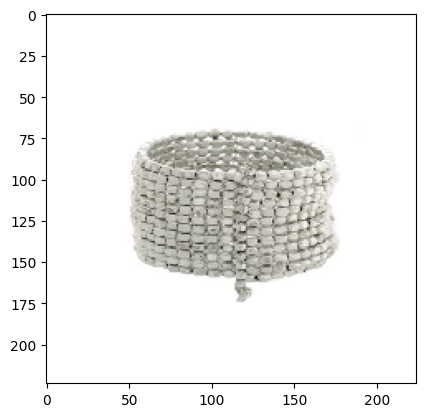

-----------------------------------------------------------------------
most similar products:


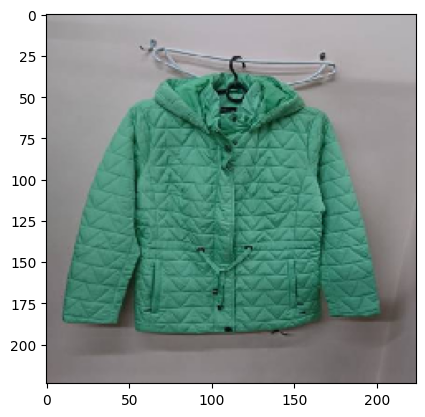

similarity score: 0.37779841493273947


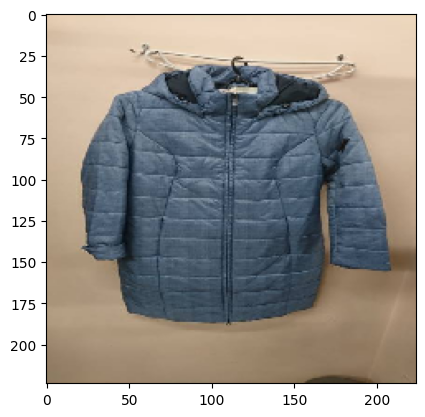

similarity score: 0.37966960562686247


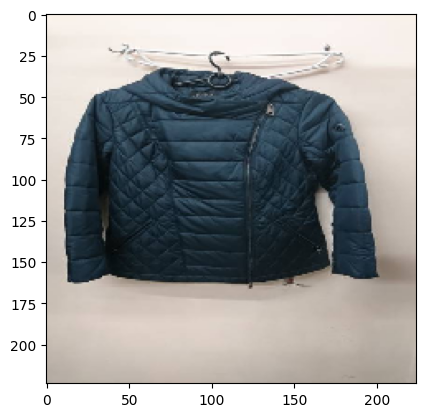

similarity score: 0.39864902112479567


0

In [ ]:
get_closest_images(files2[-1], 3)
